In [1]:
import math
import random

import os
import gym
from gym.wrappers.monitoring.video_recorder import VideoRecorder
import numpy as np
import matplotlib.pyplot as plt # Graphical library

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Configuring Pytorch

from collections import namedtuple, deque
from itertools import count
from copy import deepcopy
from math import sqrt

from IPython.display import HTML, clear_output
clear_output()

# Solution of Lab Assignment 4 :  
See pdf for instructions

## Part 1: Continuous Control

In [2]:
import math
from typing import Match

import numpy as np
from gym import logger, spaces
from gym.envs.classic_control.cartpole import CartPoleEnv
from gym.utils import seeding
from gym.wrappers.time_limit import TimeLimit

# Continuous cartpole class: this class modifies the original Gym class to be 
# able to handle continuous actions as input
# You DO NOT need to understand it to work on this lab assessment

from gym.envs.classic_control.cartpole import CartPoleEnv

class ContinuousCartPoleEnv(CartPoleEnv):
    def __init__(self, length=0.5, masspole=0.1, **kwords):
        super().__init__(**kwords)
        self.length = length
        self.masspole = 0.1
        self.polemass_length = self.masspole * self.length
        self.steps_beyond_done = None
    
    def step(self, force):

        err_msg = "%r (%s) invalid" % (force, type(force))
        assert type(force)==float, err_msg

        x, x_dot, theta, theta_dot = self.state
        
        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (
            force + self.polemass_length * theta_dot ** 2 * sintheta
        ) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length * (4.0 / 3.0 - self.masspole * costheta ** 2 / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        if self.kinematics_integrator == "euler":
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot

        self.state = (x, x_dot, theta, theta_dot)

        done = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
        )

        if not done:
            reward = 1.0
        elif self.steps_beyond_done is None:
            # Pole just fell!
            self.steps_beyond_done = 0
            reward = 1.0
        else:
            if self.steps_beyond_done == 0:
                logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned done = True. You "
                    "should always call 'reset()' once you receive 'done = "
                    "True' -- any further steps are undefined behavior."
                )
            self.steps_beyond_done += 1
            reward = 0.0

        return np.array(self.state, dtype=np.float32), reward, done, False, {}
    
    def reset(self):
        self.steps_beyond_done = None
        return super().reset()

gym.envs.register(
     id='ContinuousCartPoleEnv',
     entry_point=ContinuousCartPoleEnv,
     max_episode_steps=500,
)

## Part 2: Deep Deterministic Policy Gradients (DDPG)

In [3]:
class MLP(nn.Module):
    
    def __init__(self, layer_tuple, output_activation='relu', max_output=1):
        super(MLP, self).__init__()

        self.layers = nn.ModuleList([nn.Linear(layer_tuple[l], layer_tuple[l+1]) for l in range(len(layer_tuple)-1)])
        self.hidden_activation = nn.ReLU()

        self.max_output = max_output
        self.output_activation = nn.Identity()
        if output_activation == 'relu':
            self.output_activation = nn.ReLU()
        if output_activation == 'tanh':
            self.output_activation = nn.Tanh()

    def forward(self, x):

        for layer in self.layers[:-1]:
            x = self.hidden_activation(layer(x))
        
        return self.max_output*self.output_activation(self.layers[-1](x))

class Actor:
    def __init__(self, layers, max_force=1, device='cpu'):

        self.model = MLP(layers, output_activation='tanh', max_output=max_force).to(device)
        self.optim = optim.Adam(self.model.parameters())

        self.target = deepcopy(self.model).to(device)

    def optimise_step(self, critic, state):
        state_action = torch.cat((state, self.model(state)), dim=-1)
        
        loss = -critic.model(state_action).mean()

        self.optim.zero_grad()
        loss.backward()
        self.optim.step()

    def update_target(self, tau):
        for target_param, local_param in zip(self.target.parameters(), self.model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)



class Critic:
    def __init__(self, layers, device='cpu'):

        self.model = MLP(layers).to(device)
        self.optim = optim.Adam(self.model.parameters())

        self.target = deepcopy(self.model).to(device)
        self.target.eval()

        self.device = device

    def optimise_step(self, actor, transitions, non_final_next_states, non_final_mask, GAMMA):
        
        state, action, reward = transitions
        with torch.no_grad():
            non_final_next_state_action = torch.cat((non_final_next_states, actor.target(non_final_next_states)), dim=-1).detach().to(self.device)

            predicted_q_next = torch.zeros(len(reward)).to(self.device)

            predicted_q_next[non_final_mask] = self.target(non_final_next_state_action).squeeze()

        y = reward + GAMMA * predicted_q_next

        current_state_action = torch.cat((state, action.unsqueeze(1)), dim=-1)
        q_current = self.model(current_state_action).squeeze()

        loss = ((y - q_current)**2).mean()         
        
        #optimisation step
        self.optim.zero_grad()
        loss.backward()
        self.optim.step()

    def update_target(self, tau):
        for target_param, local_param in zip(self.target.parameters(), self.model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
        

# From OpenAI Baselines:
# https://github.com/openai/baselines/blob/master/baselines/ddpg/noise.py

class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma, theta=.15, dt=1e-3, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def noise(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt \
            + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)


from collections import namedtuple, deque
import random

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Defining the Actor and Critic models and other hyperparameters

In [4]:
NUM_EPISODES = 1500
BATCH_SIZE = 512
GAMMA = 1.
NOISE_START = 0.01
NOISE_END = 0
FINAL_NOISE_DECAY = 5   
NOISE_DECAY = NUM_EPISODES/FINAL_NOISE_DECAY     #number of episodes for epsilon to decay by 1/e
TAU = 0.001       #target update

# Get number of states and actions from gym action space
env = gym.make('ContinuousCartPoleEnv')
env.reset()
state_dim = len(env.state)    #x, x_dot, theta, theta_dot
action_dim = 1

##noise parameters
ou_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim),
                                            sigma=float(.3) * np.ones(action_dim))
ou_noise.reset()

hidden_layer_actor = 128
hidden_layer_critic = 256
actor_layers = (state_dim, hidden_layer_actor, action_dim)
critic_layers = (state_dim + action_dim, hidden_layer_critic, 1)

actor = Actor(actor_layers, max_force=1, device=device)
critic = Critic(critic_layers, device=device)

memory = ReplayMemory(20000)

/homes/fv516/rl/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/homes/fv516/rl/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


### Optimisation function for the Actor and Critic models

In [5]:
def optimise_models(actor, critic, memory, GAMMA=GAMMA, BATCH_SIZE=BATCH_SIZE):
    if len(memory) < BATCH_SIZE:
        return
    
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
   
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    critic.optimise_step(actor, (state_batch, action_batch, reward_batch), 
                         non_final_next_states, non_final_mask, GAMMA=GAMMA)
    actor.optimise_step(critic, state_batch)


### Training the Actor and Critic

In [6]:
episode_durations = []
actions_taken = []
noises = []

for i_episode in range(NUM_EPISODES):
    ep_actions = []
    ep_noise = []
    if i_episode % 20 == 0:
        print("episode ", i_episode, "/", NUM_EPISODES)
        
    # Initialize the environment and state
    env.reset()
    state = torch.tensor(env.state).float().unsqueeze(0).to(device)
    
    noise_amplitude = NOISE_END + (NOISE_START - NOISE_END) * \
        math.exp(-1. * i_episode / NOISE_DECAY)
    
    for t in count():
        noise = noise_amplitude*np.random.randn()
        noise = torch.tensor(ou_noise.noise()).to(device) * 1.0/(1.0 + 0.1*i_episode)

        actor_action = actor.model(state).flatten().detach().to(device)    #avoid backpropagating through the chosen action
        action_taken = (actor_action + noise).float()

        _, reward, terminated, truncated, _ = env.step(float(action_taken))
        done = terminated or truncated
        reward = torch.tensor([reward], device=device)
        
        # Observe new state
        if not done:
            next_state = torch.tensor(env.state).float().unsqueeze(0).to(device)
        else:
            next_state = None

        # Store transition in memory
        memory.push(state, action_taken, next_state, reward)
        
        # Move to the next state
        state = next_state
        
        # Optimise actor and critic
        optimise_models(actor, critic, memory)
        
        #Update target networks
        actor.update_target(TAU)
        critic.update_target(TAU)
        
        #End episode
        if done:
            episode_durations.append(t + 1)
            if i_episode % 20 == 0:
                print("duration  ", episode_durations[-1])
            break
        
print('Complete')

episode  0 / 1500
duration   46
episode  20 / 1500
duration   23
episode  40 / 1500
duration   32
episode  60 / 1500
duration   23
episode  80 / 1500
duration   25
episode  100 / 1500
duration   24
episode  120 / 1500
duration   38
episode  140 / 1500
duration   39
episode  160 / 1500
duration   32
episode  180 / 1500
duration   44
episode  200 / 1500
duration   41
episode  220 / 1500
duration   39
episode  240 / 1500
duration   40
episode  260 / 1500
duration   42
episode  280 / 1500
duration   32
episode  300 / 1500
duration   51
episode  320 / 1500
duration   32
episode  340 / 1500
duration   28
episode  360 / 1500
duration   32
episode  380 / 1500
duration   40
episode  400 / 1500
duration   26
episode  420 / 1500
duration   41
episode  440 / 1500
duration   62
episode  460 / 1500
duration   27
episode  480 / 1500
duration   39
episode  500 / 1500
duration   34
episode  520 / 1500
duration   43
episode  540 / 1500
duration   34
episode  560 / 1500
duration   61
episode  580 / 1500


### Visualisation of the agent

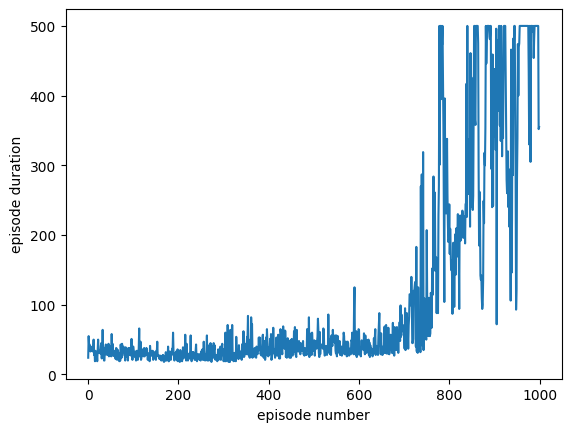

In [7]:
#learning curve for one run

plt.xlabel("episode number")
plt.ylabel("episode duration")
plt.plot(episode_durations)

In [7]:
cwd = os.getcwd()
video_dir = os.path.join(cwd, 'trained_agent')
if not os.path.isdir(video_dir):
    os.mkdir(video_dir)
video_file = os.path.join(video_dir, "trained_agent.mp4")

env = gym.make('ContinuousCartPoleEnv', render_mode="rgb_array")
video_recorder = VideoRecorder(env, video_file, enabled=True) 

#Performing the episode
state = env.reset()
done = False
state = torch.tensor(env.state).float()

duration = 0

while not done:

    # Store the current state of the CartPole for the video
    video_recorder.capture_frame()

    # Predict the state with the model
    action = actor.model(state)
    _, reward, terminated, truncated, _ = env.step(float(action))
    done = terminated or truncated
    duration += 1
    state = torch.tensor(env.state).float()


video_recorder.capture_frame()
video_recorder.close()
video_recorder.enabled = False

env.close()

Moviepy - Building video /homes/fv516/Downloads/learned_dynamics/learned_dynamics.mp4.
Moviepy - Writing video /homes/fv516/Downloads/learned_dynamics/learned_dynamics.mp4



Moviepy - Done !
Moviepy - video ready /homes/fv516/Downloads/learned_dynamics/learned_dynamics.mp4
